In [1]:
!pip3 install nltk pandas numpy sklearn matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np

In [3]:
from ast import literal_eval
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [4]:

train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

In [5]:
train.head()


,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


In [6]:
test.head()


,title
0,Warning: mysql_query() expects parameter 2 to ...
1,get click coordinates from <input type='image'...
2,How to implement cloud storage for media asset...
3,What is catcomplete in jQuery's autocomplete p...
4,Error building Android app with Cordova 3.1 CLI


In [7]:
validation.head()

,title,tags
0,Why odbc_exec always fail?,"[php, sql]"
1,Access a base classes variable from within a c...,[javascript]
2,"Content-Type ""application/json"" not required i...","[ruby-on-rails, ruby]"
3,Sessions in Sinatra: Used to Pass Variable,"[ruby, session]"
4,"Getting error - type ""json"" does not exist - i...","[ruby-on-rails, ruby, json]"


In [8]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values


In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
stopwords_english = set(stopwords.words('english'))
list(stopwords_english)[:10]

['s', 'most', 'its', 'over', 'isn', 'himself', 'can', "hadn't", "won't", 'my']

In [11]:

import re
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
# Any symbols other than these are removed
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()
    text = re.sub(REPLACE_BY_SPACE_RE, " ", text)
    text = " ".join([word for word in text.split(" ") if word not in stopwords_english])
    text = re.sub(BAD_SYMBOLS_RE, "", text) 
    text = " ".join([word for word in text.split(" ") if len(word) != 0])
    return text


In [14]:
text_prepare("SQL Server - any equivalent of Excel's CHOOSE function?")


'sql server equivalent excels choose function'

In [13]:
X_train_prepare = [text_prepare(question) for question in X_train]
X_test_prepare = [text_prepare(question) for question in X_test]
X_val_prepare = [text_prepare(question) for question in X_val]


In [14]:
pd.DataFrame({'prepared': X_train_prepare[:10], 'original': X_train[:10]})

,prepared,original
0,draw stacked dotplot r,How to draw a stacked dotplot in R?
1,mysql select records datetime field less speci...,mysql select all records where a datetime fiel...
2,terminate windows phone 81 app,How to terminate windows phone 8.1 app
3,get current time specific country via jquery,get current time in a specific country via jquery
4,configuring tomcat use ssl,Configuring Tomcat to Use SSL
5,awesome nested set plugin add new children tre...,Awesome nested set plugin - how to add new chi...
6,create map json response ruby rails 3,How to create map from JSON response in Ruby o...
7,rspec test method called,rspec test if method is called
8,springboot catalina lifecycle exception,SpringBoot Catalina LifeCycle Exception
9,import data excel mysql database using php,How to import data from excel to mysql databas...


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_prepare)
X_val_tfidf = tfidf_vectorizer.transform(X_val_prepare)
X_test_tfidf = tfidf_vectorizer.transform(X_test_prepare)
tfidf_vocabulary = tfidf_vectorizer.vocabulary_


In [16]:
print(X_train_tfidf[1])

  (0, 29588)	0.24540274618798358
  (0, 25494)	0.4064986946612677
  (0, 15353)	0.4454941760104249
  (0, 10048)	0.32287114158489333
  (0, 7133)	0.3649429374739481
  (0, 22418)	0.40323640938975913
  (0, 24149)	0.30980412500230314
  (0, 17676)	0.28295569111866237


In [17]:
from sklearn.preprocessing import MultiLabelBinarizer

y_tags = list(set(np.concatenate(y_train)))

mlb = MultiLabelBinarizer(classes=sorted(set(y_tags)))
y_train_mlb = mlb.fit_transform(y_train)
y_val_mlb = mlb.fit_transform(y_val)

In [18]:
print(y_train_mlb[1])
print(mlb.inverse_transform(y_train_mlb)[1])
print(X_train[1])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
('mysql', 'php')
mysql select all records where a datetime field is less than a specified value


In [19]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
classifier_tfidf  = LogisticRegression(solver='liblinear')
classifier_tfidf = OneVsRestClassifier(classifier_tfidf)
classifier_tfidf.fit(X_train_tfidf, y_train_mlb)

OneVsRestClassifier(estimator=LogisticRegression(solver='liblinear'))

In [20]:
y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

In [21]:

y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val_mlb)
for (question, label, pred) in zip(X_val[0:5], y_val_inversed, y_val_pred_inversed):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        question,
        ','.join(label),
        ','.join(pred)
    ))

Title:	Why odbc_exec always fail?
True labels:	php,sql
Predicted labels:	


Title:	Access a base classes variable from within a child class
True labels:	javascript
Predicted labels:	class


Title:	Content-Type "application/json" not required in rails
True labels:	ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails


Title:	Sessions in Sinatra: Used to Pass Variable
True labels:	ruby,session
Predicted labels:	


Title:	Getting error - type "json" does not exist - in Postgresql during rake db migrate
True labels:	json,ruby,ruby-on-rails
Predicted labels:	ruby-on-rails




In [22]:
from sklearn.metrics import roc_auc_score, f1_score
f1_score = f1_score(y_val_mlb, y_val_predicted_labels_tfidf, average='weighted') * 100
print("F1 Score" ,f1_score, "%")

F1 Score 59.27668540142847 %


In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
from collections import Counter
y_train_all_vals = np.concatenate(y_train)
y_train_freq = Counter(y_train_all_vals)
avg = list(y_train_freq.items())[int(len(y_train_freq) * 0.5)]
avg = [avg for _ in range(0,6)]
pd.DataFrame({"most_common": y_train_freq.most_common(6),
"least_common": y_train_freq.most_common()[-6:], "average_val": avg})

,most_common,least_common,average_val
0,"(javascript, 19078)","(wcf, 389)","(xcode, 900)"
1,"(c#, 19077)","(loops, 389)","(xcode, 900)"
2,"(java, 18661)","(python-3.x, 379)","(xcode, 900)"
3,"(php, 13907)","(sorting, 375)","(xcode, 900)"
4,"(python, 8940)","(mongodb, 350)","(xcode, 900)"
5,"(jquery, 7510)","(pointers, 350)","(xcode, 900)"


(array([82.,  9.,  2.,  2.,  1.,  0.,  0.,  1.,  0.,  3.]),
 array([  350. ,  2222.8,  4095.6,  5968.4,  7841.2,  9714. , 11586.8,
        13459.6, 15332.4, 17205.2, 19078. ]),
 <BarContainer object of 10 artists>)

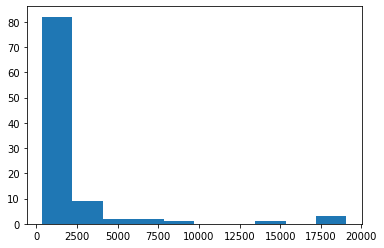

In [25]:
plt.hist(y_train_freq.values())

In [26]:
mlb.inverse_transform(classifier_tfidf.predict(tfidf_vectorizer.transform(["visual c++"])))

[('c++', 'vb.net', 'visual-studio')]